In [3]:
import sys
import os
import pickle
from topolearn import *
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")


In [1]:
import cvxpy as cp

In [2]:
print(cp.installed_solvers())

['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [5]:
prob_T=0.7

# Load the graph
G = EnhancedGraph(n=40, p_edges=0.162, p_triangles=prob_T, seed=0)
B1 = G.get_b1()
B2 = G.get_b2()

# Sub-sampling if needed to decrease complexity
sub_size = 100
# Compute Laplacians
Lu, Ld, L = G.get_laplacians(sub_size=sub_size)
Lu_full = G.get_laplacians(sub_size=sub_size, full=True)

# Sub-sampling
B1, B2 = G.sub_size_skeleton(B1, B2, sub_size=sub_size)
B2 = G.triangles_only(B2)
B2_true = G.mask_B2(B2)
# B1 = B1[:, :sub_size]
# B2 = B2[:sub_size, :]
# B2 = B2[:,np.sum(np.abs(B2), 0) == 3]
nu = B2.shape[1] # N2
nd = B1.shape[1] # N1
T = int(np.ceil(nu*(1-prob_T)))

# Laplacians
Lu_true, Ld, L = G.get_laplacians(sub_size=100)
Lu_full = G.get_laplacians(sub_size=100, full=True)
B2_true = G.mask_B2(B2)
M =  L.shape[0]


# Problem and Dictionary Dimensionalities
dictionary_type="separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
P = 3 # Number of Kernels (Sub-dictionaries)
J = 2 # Polynomial order
sparsity_mode = "random"
n_search = 3000
n_sim = 10

# Data-Independent Problem Hyperparameters
K0_coll = np.arange(5,26,4)
K0_max = 25
max_iter = 100 
patience = 5 
tol = 1e-3 # tolerance for Patience
lambda_ = 1e-7 # l2 multiplier
verbose = True

T_coll = [0.5, 0.6, 0.7, 0.8, 0.9]

In [6]:
B2.shape

(100, 62)

In [7]:
Lu_true

array([[ 3., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]], shape=(100, 100))

In [7]:
Lu_true

array([[ 3., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [9]:
Lu_true

array([[ 3., -1., -1., ...,  0.,  0.,  0.],
       [-1.,  3.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [8]:
T

19

In [140]:
p_star = np.where(np.sum(B2_true, axis=0)>0, 1, 0)
# p_star
np.reshape(p_star[:-2], (-1, 6))

array([[1, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1],
       [1, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 0, 1],
       [1, 1, 1, 1, 1, 1]])

In [44]:
def plot_error(list_, error=False, tmp=False):
    # Concatenate the arrays
    out = np.array([np.array(a) for a in list_])
    out = np.concatenate(out)

    # Initialize the start index
    start = 0

    # Create the plot
    plt.figure(figsize=(10, 5))

    # Loop through the original list_ to determine segment colors
    for idx, sub_array in enumerate(list_):
        end = start + len(sub_array)  # Determine the end index of the current segment
        if idx % 2 == 0:  # Even index
            color = 'red'
        else:  # Odd index
            color = 'blue'
        
        # Plot the segment
        plt.plot(range(start, end), out[start:end], color=color)
        
        if idx>0 and idx < len(list_)-1:  # Connect segments with a line
            plt.plot([start - 1, start], [out[start - 1], out[start]], color=color)

        start = end  # Update the start index for the next segment

    plt.xlabel("Iteration")
    if error:
        y_label = "MSE"
    else:
        y_label = "Objective Function"
    plt.ylabel(y_label)
    lab="(h, S)" if tmp else "(h, S, p)"
    plt.legend([f"{lab} optimization", "(h,S) optimization"], loc="upper right")
    plt.show()

In [ ]:
path = os.getcwd()
s = 25
rr = f"results\\final\\max_sparsity{s}\\tri_learnS5Greedy.pkl"
with open(f"{path}\\{rr}", "rb") as fff:
    mmm = pickle.load(fff)
    ddd = pickle.load(fff)

In [35]:
path = os.getcwd()
# s = 5
rr = f"results\\final\\max_sparsity{s}\\tri_learnS15GreedyT507090.pkl"
with open(f"{path}\\{rr}", "rb") as fff:
    m1 = pickle.load(fff)
    d1 = pickle.load(fff)

In [39]:
d1[2]["complete_greedy"]

(array([[0.02518787],
        [0.02372257],
        [0.03264922],
        [0.02602927],
        [0.02763287],
        [0.02788137],
        [0.02803669],
        [0.03209786],
        [0.0201919 ],
        [0.02487106]]),
 array([[0.02669212],
        [0.02136463],
        [0.0323449 ],
        [0.02355285],
        [0.03170067],
        [0.03030989],
        [0.02529828],
        [0.03006149],
        [0.02113451],
        [0.02454646]]),
 array([[0.        ],
        [0.10567049],
        [0.        ],
        [0.10580184],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.19008034]]))

In [22]:
len(ddd)

1

In [11]:
p_tr = [0.3, 0.5, 0.9, 0.4, 0.2, 0.6]
for i,p in enumerate(p_tr):
    my_df2 = pd.concat([my_df2, pd.DataFrame({"Error": ddd[i]["complete_greedy"][2].flatten(),
                                    "Method": "greedy",
                                    "Triangles": int(p*100)})])

IndexError: list index out of range

In [8]:
p_tr = [0.3, 0.5, 0.9, 0.4, 0.2, 0.6]
my_df3 = pd.DataFrame()
for i,p in enumerate(p_tr):
    for s in range(10):
        a = []
        for arr in mmm[i][(s,0)][0].train_error_hist:
            a += arr
            # print(a)
        my_df3 = pd.concat([my_df3, pd.DataFrame({"Error": a,
                                    "Method": "greedy",
                                    "Sim": s,
                                    "Triangles": int(p*100)})])

In [9]:
my_df3[my_df3["Triangles"]==30]

,Error,Method,Sim,Triangles
0,0.329893,greedy,0,30
1,0.276659,greedy,0,30
2,0.243125,greedy,0,30
3,0.224002,greedy,0,30
4,0.206412,greedy,0,30
...,...,...,...,...
90,0.166592,greedy,9,30
91,0.166396,greedy,9,30
92,0.166372,greedy,9,30
93,0.165781,greedy,9,30


In [26]:
path = os.getcwd()
s = 5
rr = f"results\\final\\max_sparsity{s}\\tri_learnS5greedy20.pkl"
with open(f"{path}\\{rr}", "rb") as fff:
    m1 = pickle.load(fff)
    d1 = pickle.load(fff)

In [30]:
import re
rr = f"results\\final\\max_sparsity{s}\\tri_learnS5greedy20607090.pkl"
s_pre = rr.split('.')[0]
matches = re.findall(r'(?<=[A-Za-z])((?:\d{2})+)', s_pre)
tr_list = []
for match in matches:
    tr_list.extend([int(match[i:i+2]) for i in range(0, len(match), 2)])
word_match = re.search(r'(greedy|soft)', s_pre)
algo_method = word_match.group(1) if word_match else None

In [31]:
tr_list

[20, 60, 70, 90]

In [381]:
p_tr = [20]
for i,p in enumerate(p_tr):
    for s in range(10):
        a = []
        if s==0:
            continue
        for arr in m1[i][(s,0)][0].train_error_hist:
            a += arr
        my_df3 = pd.concat([my_df3, pd.DataFrame({"Error": a,
                                    "Method": "soft",
                                    "Sim": s,
                                    "Triangles": p})])

# my_df3= pd.concat([my_df3, pd.DataFrame({"Error":})])

NameError: name 'my_df3' is not defined

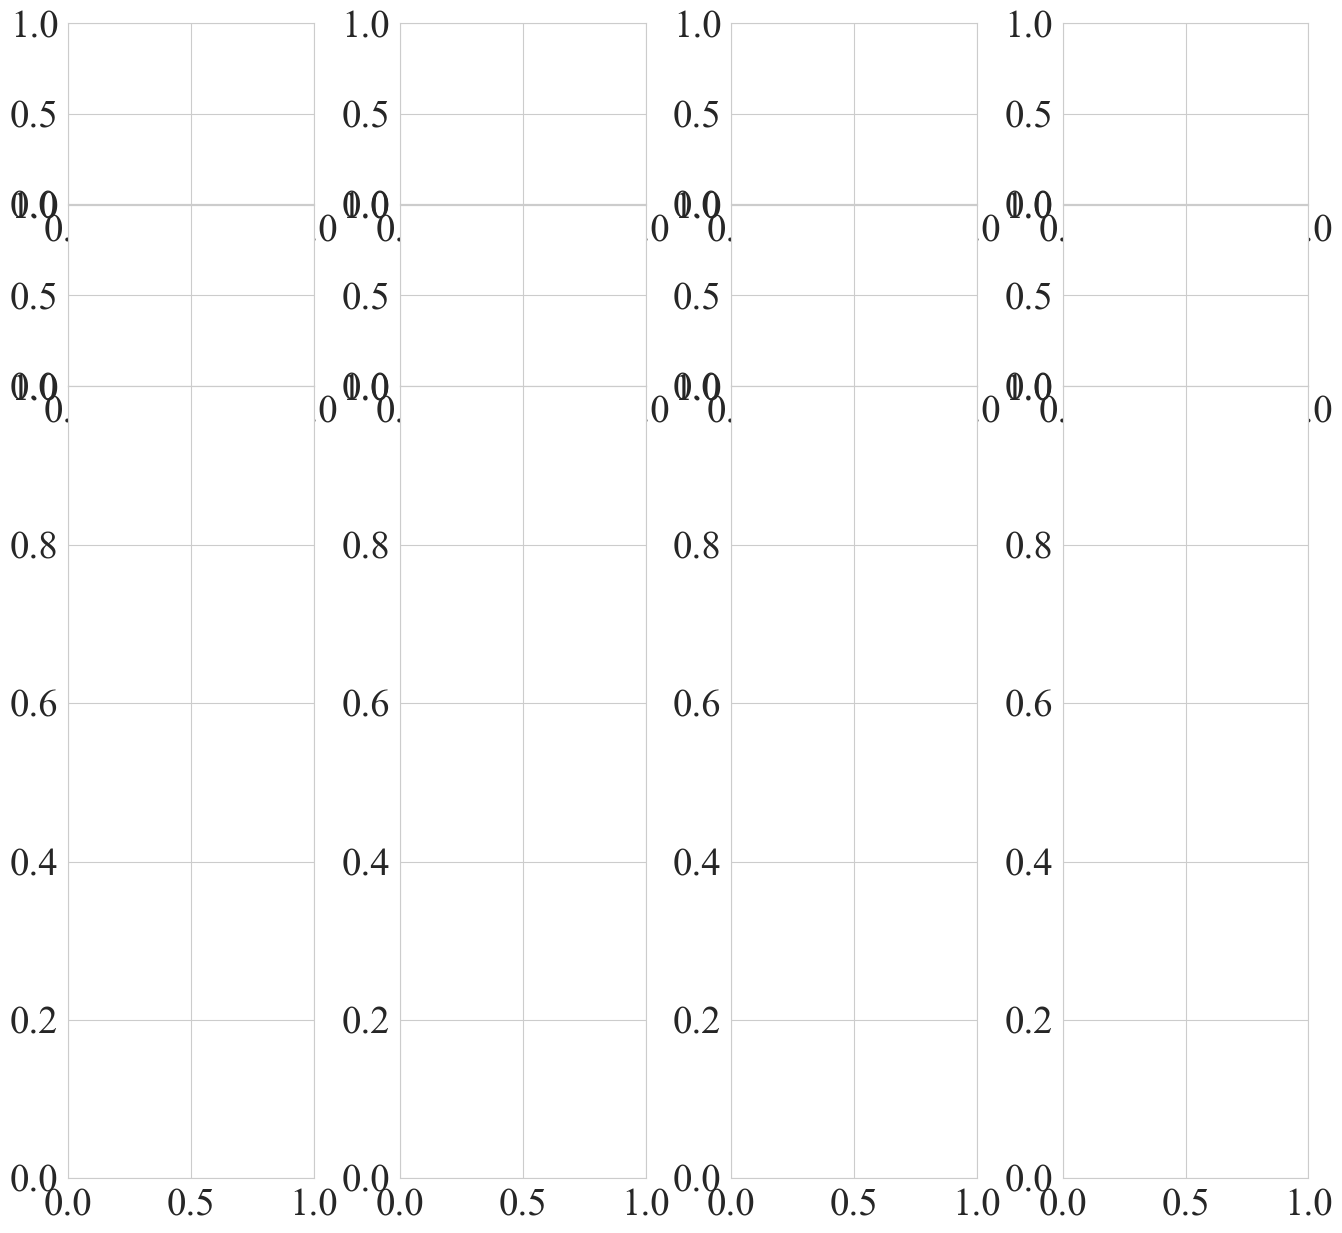

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set fixed categories for Triangles
triangle_categories = [20, 30, 40, 50]

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28
plt.rcParams["font.size"] = 28
plt.rcParams['axes.titlesize'] = 28
plt.rcParams["font.family"] = "Times New Roman"

# Create subplots
fig, axes = plt.subplots(3, 4, figsize=(16, 15), gridspec_kw={'height_ratios': [0.8, 0.8, 3.5], 'wspace': 0.35, 'hspace': 0.0015})

# Plot for each category
for i, category in enumerate(triangle_categories):
    df_filtered = my_df3[my_df3['Triangles'] == category]
    
    # Plot for greedy method
    df_greedy = df_filtered[df_filtered['Method'] == 'greedy']
    sns.lineplot(data=df_greedy, x=df_greedy.index, y="Error", hue="Sim", palette="rocket", legend=False, ax=axes[1, i])
    
    # Plot for soft method
    df_soft = df_filtered[df_filtered['Method'] == 'soft']
    sns.lineplot(data=df_soft, x=df_soft.index, y="Error", hue="Sim", palette="Greens", legend=False, ax=axes[0, i])
    
    # Restore ticks
    axes[0, i].set_xticks([])
    # axes[0, i].set_yticks([])
    axes[1, i].set_xticks([])
    # axes[1, i].set_yticks([])
    
    # Set titles for the first row
    axes[0, i].set_title(f"Triangles = {category}%")
    
    axes[0, i].set_xlabel("")
    axes[1, i].set_xlabel("")
    axes[0, i].set_ylabel("")
    axes[1, i].set_ylabel("")

# Remove common ylabel for the first two rows

# Add bottom plot across all columns
markers = ["d", "o"]
my_plt = sns.lineplot(
    data=my_df2,
    x="Triangles",
    y="Error",
    hue="Method",
    markers=markers,
    palette=np.array([sns.color_palette()[2], sns.color_palette("rocket")[0]]),
    markersize=20,
    dashes=False,
    style="Method",
    linewidth=3,
    estimator="mean",
    errorbar=None,
    sort=False,
    ax=axes[2, 0]
)

# Span the last plot across all columns
for i in range(1, 4):
    fig.delaxes(axes[2, i])
axes[2, 0].set_position([0.1, 0.23, 0.8, 0.38])  # Adjust position to bring subplots closer and increase bottom plot height

# Apply log scale
# axes[2, 0].set(yscale="log")

# Set labels
axes[2, 0].set_ylabel(r"NMSE$(\mathbf{L}^{(u)},\widehat{\mathbf{L}}^{(u)})$", fontsize=28)
axes[2, 0].set_xlabel(f"% of Triangles", fontsize=28)

# Configure legend
axes[2, 0].legend(
    labels=["Soft", "Greedy"],
    title="Topology Learning Method",
    fontsize=28,
    title_fontsize=28
)

# Adjust layout
plt.tight_layout()
# plt.savefig("latenight_plot.pdf", format="pdf", bbox_inches='tight')
plt.show()


In [267]:
np.array([sns.color_palette("rocket")[0], sns.color_palette()[3]])

array([[0.20973515, 0.09747934, 0.24238489],
       [0.83921569, 0.15294118, 0.15686275]])

In [456]:
my_df2[(my_df2["Triangles"]==50) & (my_df2["Method"]=="greedy")]["Error"][:-1].mean()

0.017010345435994292

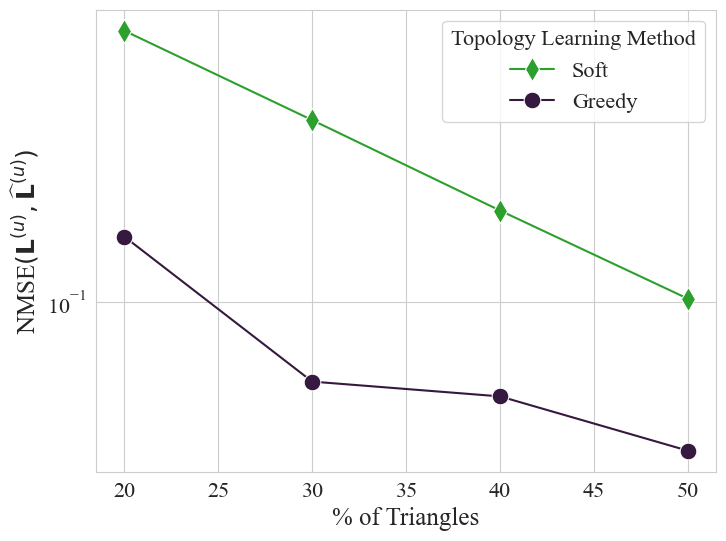

In [321]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams["font.family"] = "Times New Roman"
markers = ["d", "o"]
my_plt = sns.lineplot(
    data=my_df2,
    x="Triangles",
    y="Error",
    hue="Method",
    markers=markers,
    palette=np.array([sns.color_palette()[2], sns.color_palette("rocket")[0]]),
    markersize=12,
    dashes=False,
    style="Method",
    estimator="mean",
    errorbar=None,
    sort=False
)

my_plt.set(yscale="log")

my_plt.set_ylabel(r"NMSE$(\mathbf{L}^{(u)},\widehat{\mathbf{L}}^{(u)})$", fontsize=18)
my_plt.set_xlabel(f"% of Triangles", fontsize=18)

plt.legend(
    labels = ["Soft", "Greedy"],
    title= "Topology Learning Method",  # Set custom legend title
    fontsize=16,             # Set legend font size
    title_fontsize=16        # Set title font size
)
plt.savefig("LaplacianError2.pdf", format="pdf")
plt.show()
# plt.savefig(f"{name}.pdf", format="pdf")
# plt.show()

In [284]:
labels

['soft', 'greedy']

In [45]:
path = os.getcwd()
s = 25
t = 70
name = f'T{t}_max{s}'
res = f"results\\final\\max_sparsity{s}\\res_separated_{name}.pkl"
with open(f"{path}\\{res}", "rb") as fff:
    _ = pickle.load(fff)
    dict_errors2 = pickle.load(fff)

In [87]:
dict_errors2

{'classic_fourier': (array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

In [98]:
name = f'T{t}_official2'
res = f"results\\final\\max_sparsity{s}\\res_separated_{name}.pkl"
with open(f"{path}\\{res}", "wb") as fff:
    pickle.dump(models, fff)
    pickle.dump(dict_errors, fff)

In [46]:
path = os.getcwd()
s = 25
t = 70
name = f'T{t}_official2'
res = f"results\\final\\max_sparsity{s}\\res_separated_{name}.pkl"
with open(f"{path}\\{res}", "rb") as fff:
    models2 = pickle.load(fff)
    dict_errors2 = pickle.load(fff)

In [47]:
dict_errors2

{'classic_fourier': (array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

In [44]:
path = os.getcwd()
s = 25
t = 70
name = f'T{t}_official'
res = f"results\\final\\max_sparsity{s}\\res_separated_{name}.pkl"
with open(f"{path}\\{res}", "rb") as fff:
    models = pickle.load(fff)
    dict_errors = pickle.load(fff)

In [48]:
dict_errors["joint"] = dict_errors2["joint"]

In [49]:
dict_errors

{'classic_fourier': (array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

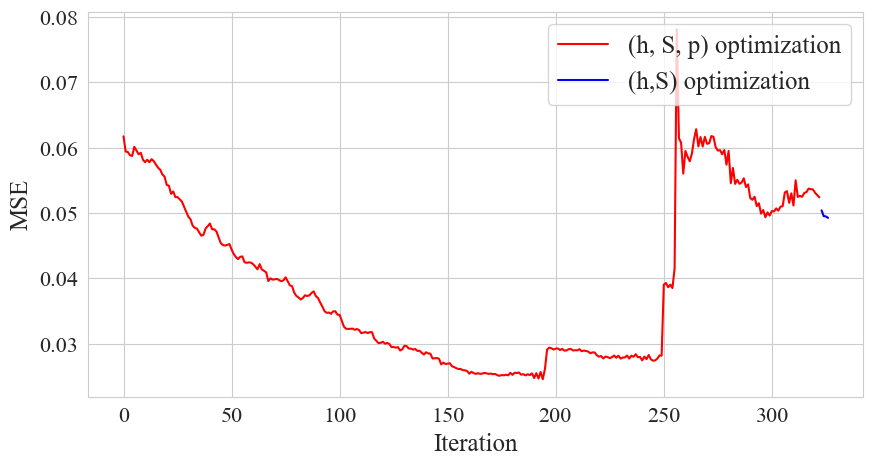

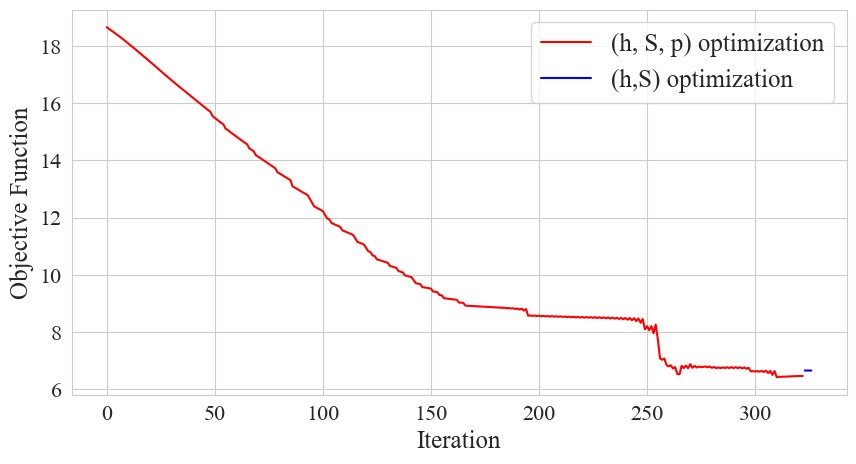

In [57]:
list1= models[(5, 4)][1].train_error_hist
list2= models[(5, 4)][1].train_history

plot_error(list1, error=True)
plot_error(list2)

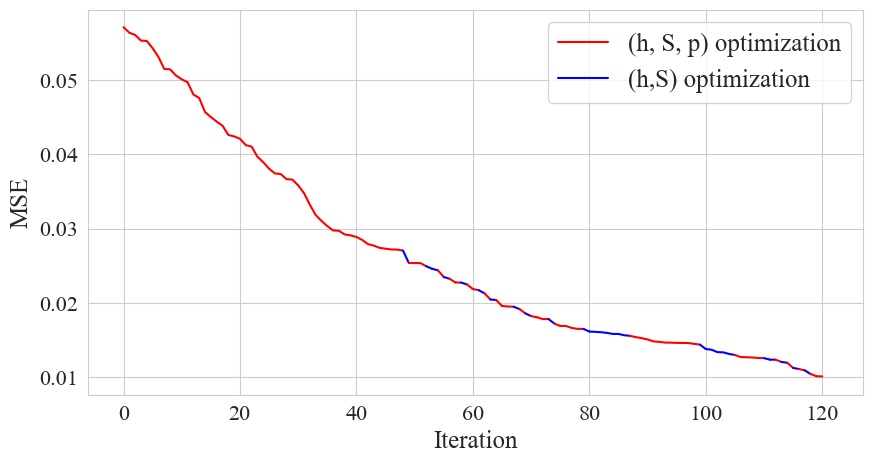

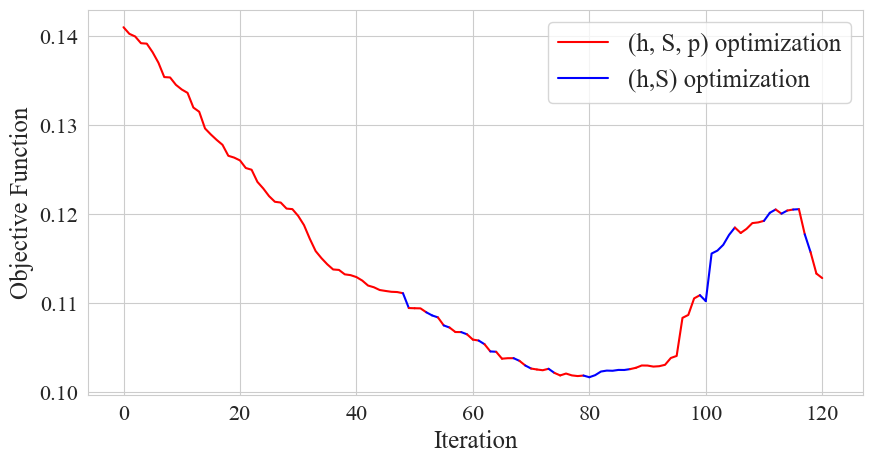

In [54]:
list1= models[(0, 4)][0].train_error_hist
list2= models[(0, 4)][0].train_history

plot_error(list1, error=True)
plot_error(list2)

In [43]:
dict_errors["complete"][2]

array([[0.        , 0.15349335, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.31527383, 1.16904519, 0.43485925, 0.        , 0.79906048,
        1.46851004],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.6159924 , 0.        , 1.95401684, 0.        , 0.        ,
        6.3420992 ],
       [0.40560588, 0.15349335, 0.15855493, 0.91086241, 0.63184239,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.15349335, 0.15349335, 0.        ,
        0.22445007],
       [0.1594482 , 0.5990584 , 0.33914005, 0.        , 0.        ,
        0.        ]])

In [41]:
dict_errors["complete_greedy"][2]

array([[0.        , 0.        , 0.        , 0.        , 0.12521758,
        0.1254363 ],
       [0.12609941, 0.        , 0.22654912, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.12456822, 0.        , 0.12456822, 0.        , 0.        ,
        0.29802823],
       [0.        , 0.        , 0.125     , 0.33451161, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.12456822],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.26532998, 0.        , 0.        , 0.1254363 ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.18242223],
       [0.18009007, 0.12565617, 0.        , 0.        , 0.        ,
        0.        ]])

In [79]:
dict_errors.keys()

dict_keys(['classic_fourier', 'fourier', 'edge', 'joint', 'separated', 'complete', 'complete_greedy'])

In [296]:
dict_errors

{'classic_fourier': (array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]),
  array([[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

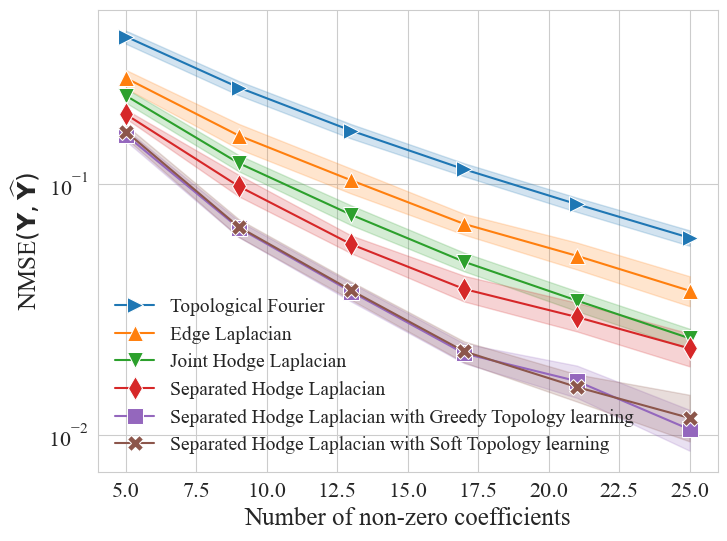

In [55]:
dict_types2 = {
    "fourier": "Topological Fourier",
    "edge": "Edge Laplacian",
    "joint": "Joint Hodge Laplacian",
    "separated": "Separated Hodge Laplacian",
    "complete_greedy": "Separated Hodge Laplacian with Greedy Topology learning",
    "complete": "Separated Hodge Laplacian with Soft Topology learning",
}

# TITLE = [dict_types[typ] for typ in dict_types.keys() if typ in dictionary_type][0]
res_df2 = pd.DataFrame()
for typ in dict_types2.keys():
    tmp_df2 = pd.DataFrame(dict_errors2[typ][0])
    # tmp_df2 = tmp_df2.mask(tmp_df2>1e5, None)
    # print(typ)
    # print(tmp_df2)
    tmp_df2.columns = K0_coll
    tmp_df2 = tmp_df2.melt(var_name="Sparsity", value_name="Error")
    tmp_df2["Method"] = dict_types2[typ] if typ in dict_types2.keys() else None
    pass
    res_df2 = pd.concat([res_df2, tmp_df2]).reset_index(drop=True)

markers = (
    [">", "^", "v", "d"]
    if len(dict_errors.keys()) == 4
    else [">", "^", "v", "d", "s", "X"]
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.rcParams['xtick.labelsize'] = 16 
plt.rcParams['ytick.labelsize'] = 16  
plt.rcParams["font.size"] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams["font.family"] = "Times New Roman"
my_plt = sns.lineplot(
    data=res_df2,
    x="Sparsity",
    y="Error",
    hue="Method",
    palette=sns.color_palette()[: len(dict_errors)],
    markers=markers,
    markersize=12,
    dashes=False,
    style="Method",
)

my_plt.set(yscale="log")

my_plt.set_ylabel(r"NMSE$(\mathbf{Y},\widehat{\mathbf{Y}})$", fontsize=18)
my_plt.set_xlabel(f"Number of non-zero coefficients", fontsize=18)
handles, labels = my_plt.get_legend_handles_labels()
my_plt.legend(handles=handles[0:], labels=labels[0:])
plt.legend(
    fontsize=14,
    frameon=False,              # Display a frame around the legend
    framealpha=0.3              
)

plt.savefig(f"{name}.pdf", format="pdf", bbox_inches='tight')
plt.show()

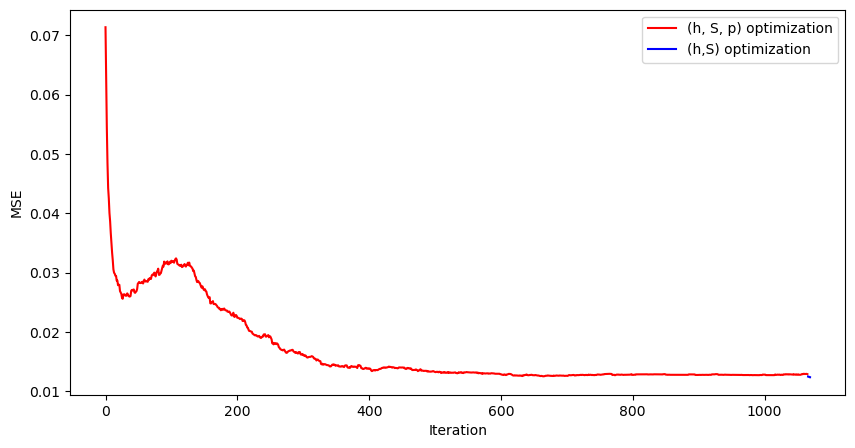

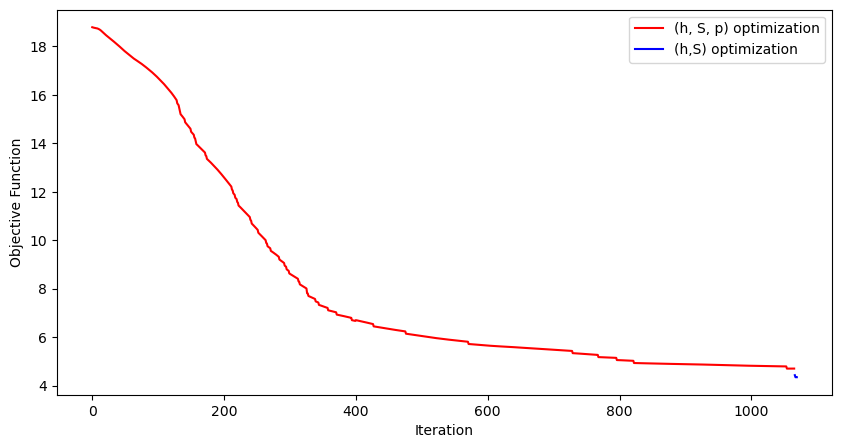

In [74]:
# with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_max25_tmp.pkl", "wb") as rr:
#     pickle.dump(models_max25_T70, rr)
#     pickle.dump(dict_errors_max25_T70, rr)

with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T20_max25.pkl", "rb") as fffr:
    models_max25_T20 = pickle.load(fffr)
    dict_errors_max25_T20 = pickle.load(fffr)

i=0

list1= models_max25_T20[(0, i)][0].train_error_hist
list2= models_max25_T20[(0, i)][0].train_history

plot_error(list1, error=True)
plot_error(list2)

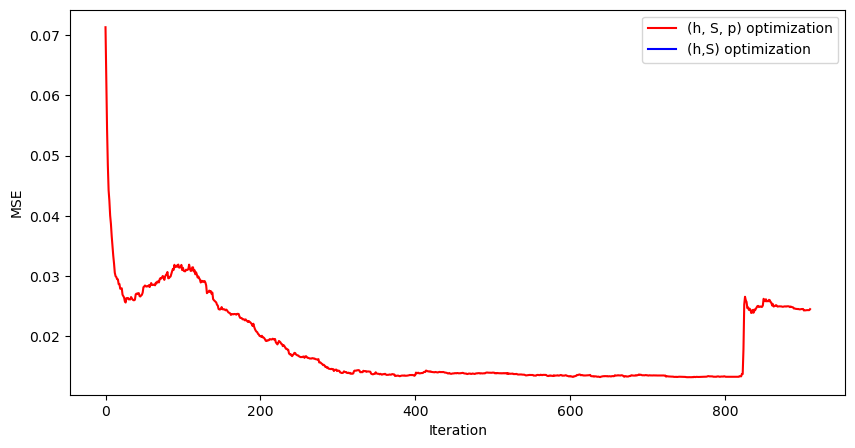

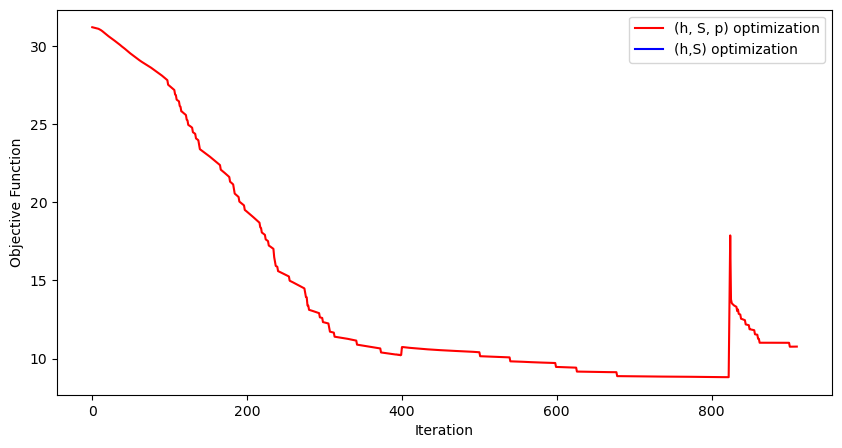

In [76]:
with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T20_max25.pkl", "rb") as fffr:
    models_max25_T20 = pickle.load(fffr)
    dict_errors_max25_T20 = pickle.load(fffr)

i=0

list1= models_max25_T20[(0, i)][0].train_error_hist
list2= models_max25_T20[(0, i)][0].train_history

plot_error(list1, error=True)
plot_error(list2)

In [86]:
models_max25_Tmp

{(0, 0): [<topolearn.TopoSolver.TopoSolver at 0x1b4e5524ca0>]}

In [8]:
models_max25_Tmp

{(0, 0): [<topolearn.TopoSolver.TopoSolver at 0x2168dd16070>]}

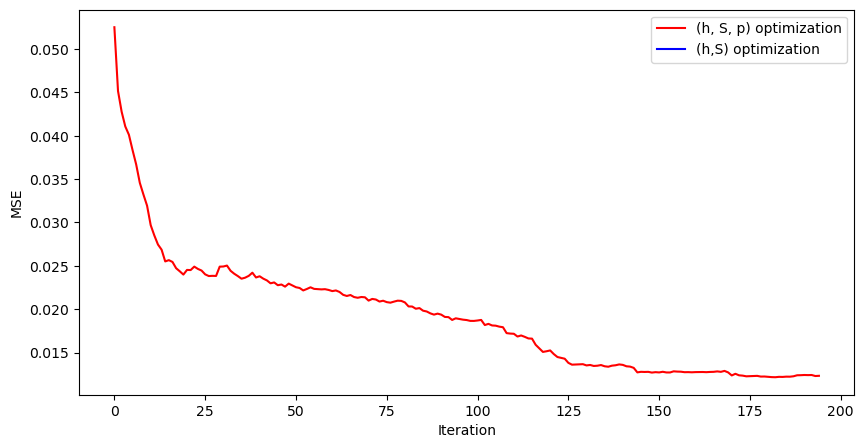

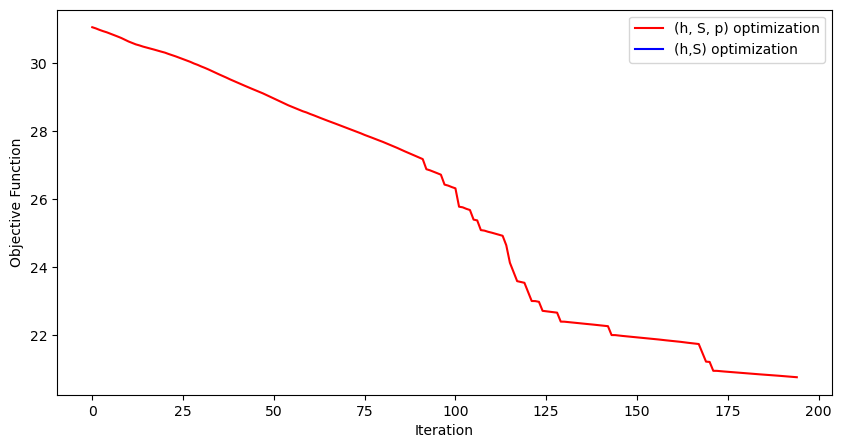

In [7]:
# with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T70_max25_tmp.pkl", "wb") as rr:
#     pickle.dump(models_max25_T70, rr)
#     pickle.dump(dict_errors_max25_T70, rr)

TT = 7
with open(f"{path}\\results\\final\\max_sparsity25\\res_separated_T{TT}0_max25.pkl", "rb") as fffr:
    models_max25_Tmp = pickle.load(fffr)
    dict_errors_max25_Tmp = pickle.load(fffr)

i=0

list1= models_max25_Tmp[(0, i)][0].train_error_hist
list2= models_max25_Tmp[(0, i)][0].train_history

plot_error(list1, error=True)
plot_error(list2)

In [94]:
p_star = np.where(np.sum(B2_true, axis=0)>0, 1, 0)
# p_star
np.reshape(p_star[:-2], (-1, 6))

array([[1, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0]])

In [75]:
p_star[-2:]

array([1, 0])

In [109]:
models_max25_Tmp[(0, i)][0].p

array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0])

In [347]:
mask = np.where(models_max25_T20[(0, i)][0].p_probs > 0.8)[0]

In [348]:
models_max25_T20[(0, i)][0].p_probs[mask]

array([0.94499163, 0.9686525 , 0.96409992, 0.88425966, 1.        ,
       1.        , 1.        , 1.        , 0.97331673, 0.97186301])

In [349]:
p_star[mask]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [317]:
np.where(a>1)[0].sha

(array([1, 2, 3], dtype=int64),)

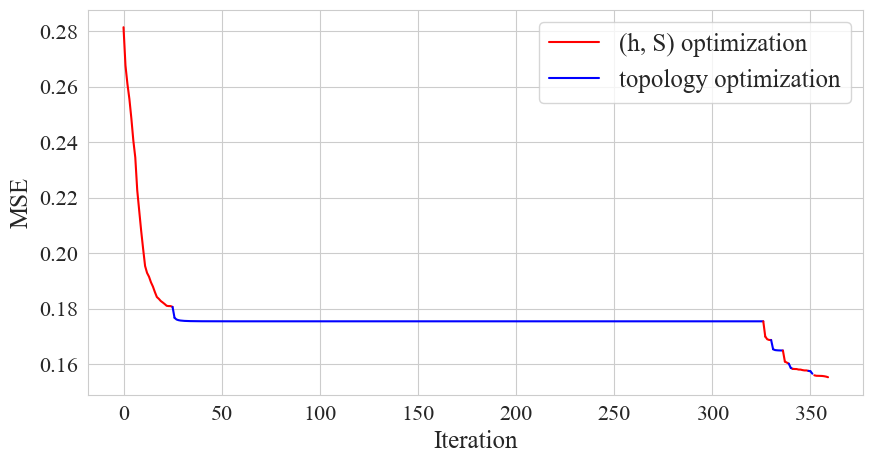

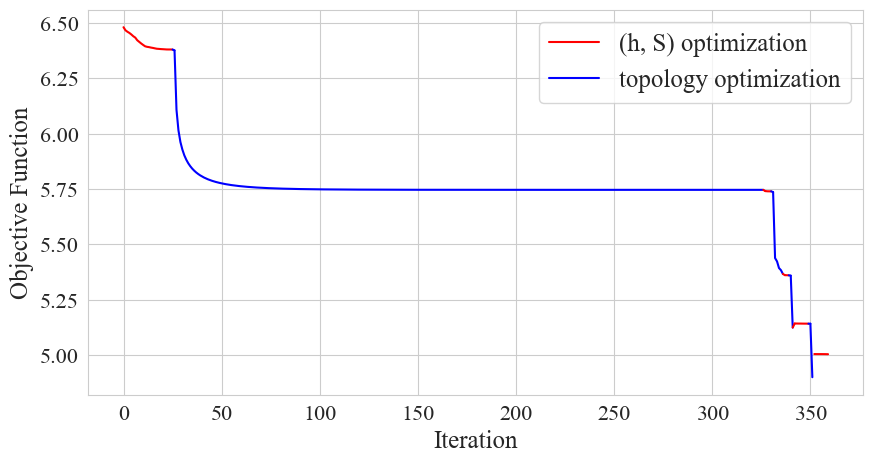

In [190]:
list1= models_max25_T70_tmp[(0, i)][1].train_error_hist
list2= models_max25_T70_tmp[(0, i)][1].train_history

plot_error(list1, error=True, tmp=True)
plot_error(list2, tmp=True)